In [222]:
from astropy.io import ascii
from astropy.table import vstack,Table,Column
import matplotlib.pyplot as plt
import numpy as np
import sncosmo
from _sncosmo_ported_model import SN91bgSource
from snana_read import read_lc

def sncosmo_fit(table,mod,band):
    """
    Do light-curve fit using SNcosmo
    
    Args:
        table (table): data to be fitted
        mod     (str): which model to use for lc-fit
        band    (str): which band to fit('b' for u,g; 'r' for r,i,z; 'all' for u,g,r,i,z)
    
    return:
        raw data, fitting result and model used
    """
    #creat mask for each band
    mask={}
    for i in 'ugriz':
        mask[i]=table['band']==('sdss'+i)
    if mod=='salt2':
        model=sncosmo.Model(source=mod)
        fit_params=['z', 't0', 'x0', 'x1', 'c']
        bounds={'z':(0.01,0.45)}
    if mod=='91bg':
        model=sncosmo.Model(source=SN91bgSource())
        fit_params=['z', 't0', 'amplitude', 'stretch', 'color']
        bounds={'z':(0.01,0.45), 'stretch':(0.65,1.25), 'color':(0,1)}
    if mod=='nugent-sn91bg':
        model=sncosmo.Model(source=mod)
        fit_params=['z','t0','amplitude']
        bounds={'z':(0.01,0.45)}
    #model.set(z=table.meta['z'])
    # which band to fit, red or blue
    if band=='b':
        data=table[mask['u']+mask['g']]
    elif band=='r':
        data=table[mask['r']+mask['i']+mask['z']]
    elif band=='all':
        data=table   #[table['band']!='sdssz']
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model,fit_params, bounds=bounds)
    return data, result, fitted_model

/anaconda3/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


reduced chi^2: 52.4060516130492


OrderedDict([('z', '0.05095'),
             ('t0', '53655.601562'),
             ('x0', '1.9420e-15'),
             ('x1', '1.001499'),
             ('c', '0.715309')])

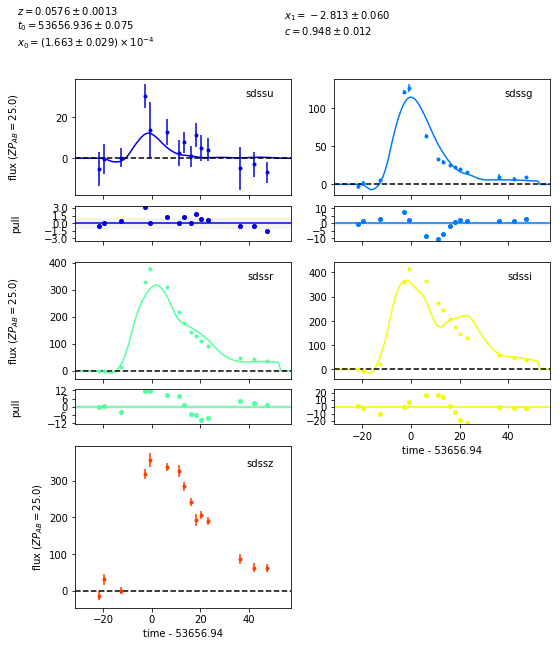

In [55]:
cid=3
data=read_lc(50000+cid)
model=sncosmo.Model(source='salt2')
result,fitted_model=sncosmo.fit_lc(data, model, ['z','t0','x0', 'x1', 'c'],\
                                        bounds={'z':(.01,.1)})
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)
print('reduced chi^2:',result.chisq/result.ndof)
data.meta

reduced chi^2: 1.0080517147154961
sim_z: 0.05095
sim_t0: 53655.601562
sim_stretch: 1.001499
sim_color: 0.715309


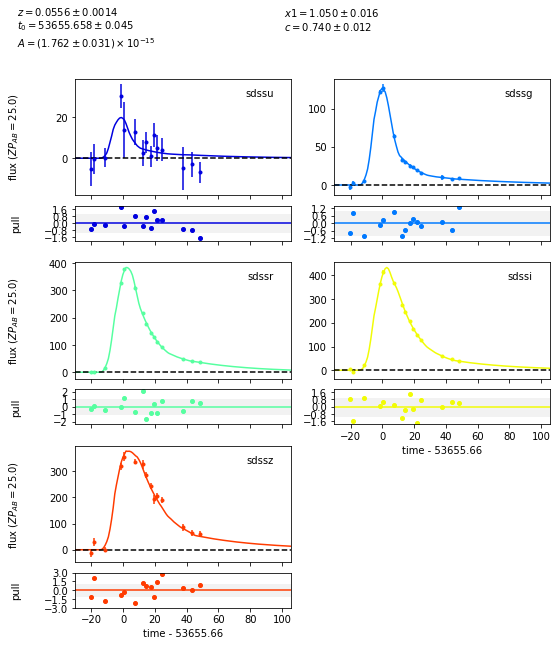

In [218]:
cid=3
data=read_lc(50000+cid)
model=sncosmo.Model(source=SN91bgSource())
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z','t0','amplitude', 'stretch', 'color'],
                                      bounds={'z': (0.01, 0.1),'stretch': (0.65, 1.25),'color': (0, 1)})
#data, result, fitted_model = sncosmo_fit(data,'91bg','all')
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)
print('reduced chi^2:',result.chisq/result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['x1'])
print('sim_color:', data.meta['c'])

Fitting with fixed simulation results

In [221]:
cid=3
data=read_lc(50000+cid)
model=sncosmo.Model(source=SN91bgSource())
model.set(z=data.meta['z'], stretch=data.meta['stretch'], color=data.meta['color'])
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['t0','amplitude'],
                                      bounds=None)
#data, result, fitted_model = sncosmo_fit(data,'91bg','all')
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)
print('reduced chi^2:',result.chisq/result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['x1'])
print('sim_color:', data.meta['c'])

FileNotFoundError: [Errno 2] No such file or directory: 'SNANA_sim/91bg_1/91bg_1_SN050003.DAT'

# Output all fitting results

In [220]:
def fit_all(num,mod,band):
    """
    Run lc-fit for a series of SNe with both salt2 and sn91bg model, output all the fitting results
    
    Args:
        num  (int): how many SN to fit
        mod  (str): which model to use
        band (str): which bands to fit, 'r' for red, 'b' for blue and other strings for all
    
    """
    lc=range(num)
    sim_x1=[]
    sim_c=[]
    sim_z=[]
    fit_z=[]
    fit_x1=[]
    fit_c=[]
    chisq=[]
    redchisq=[]
    cid=[]
    for i in lc:
        try:
            meta=Table.read('SNANA_sim/SNcosmo_format/meta.csv')
            table=Table.read('SNANA_sim/SNcosmo_format/sn91bg_'+str(50000+i+1)+'.csv')
            for par in ['z','t0','x1','c']:
                table.meta[par]=meta[par][i]
            data,result,fitted_model=sncosmo_fit(table,mod,band)
            sim_x1.append(data.meta['x1'])
            sim_c.append(data.meta['c'])
            sim_z.append(data.meta['z'])
            fit_x1.append(round(result.parameters[3],6))
            fit_c.append(round(result.parameters[4],6))
            fit_z.append(round(result.parameters[0],6))
            chisq.append(round(result.chisq,5))
            redchisq.append(round(result.chisq/result.ndof,5))
            cid.append(50000+i+1)
        except:
            continue
    result=Table([cid, sim_z, fit_z, sim_x1, fit_x1, sim_c, fit_c, chisq, redchisq], \
                       names=['cid','sim_z','fit_z','sim_x1','fit_x1','sim_c','fit_c','chi^2','redchi^2'])
    result.write('SNcosmo_result/set_z/'+mod+'_'+band+'_fit.csv',overwrite=True)


# Output fitting results in red/blue bands

In [129]:
for m in ['91bg','salt2']:
    fit_all(1000,m,'all')
    #fit_all(1000,m,'b')
    #fit_all(1000,m,'r')

/anaconda3/lib/python3.6/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdssz(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:117: RuntimeWarning: invalid value encountered in multiply
  return np.sum(wave * trans * f, axis=1) * dwave / HC_ERG_AA


# Difference between salt2 and 91bg template fit in blue bands vs. red bands

In [199]:
salt2_b=Table.read('SNcosmo_result/set_z/salt2_b_fit.csv')
salt2_r=Table.read('SNcosmo_result/set_z/salt2_r_fit.csv')
sn91bg_b=Table.read('SNcosmo_result/set_z/91bg_b_fit.csv')
sn91bg_r=Table.read('SNcosmo_result/set_z/91bg_r_fit.csv')
m_salt2_r=np.full(len(salt2_r),False)
m_91bg_r=np.full(len(sn91bg_r),False)
m_salt2_b=np.full(len(salt2_b),False)
m_91bg_b=np.full(len(sn91bg_b),False)
com_id=np.intersect1d(sn91bg_b['cid'],
               np.intersect1d(sn91bg_r['cid'],
                              np.intersect1d(salt2_b['cid'], salt2_r['cid'])))
for i in com_id:
    m_salt2_r=m_salt2_r+(salt2_r['cid']==i)
    m_salt2_b=m_salt2_b+(salt2_b['cid']==i)
    m_91bg_r=m_91bg_r+(sn91bg_r['cid']==i)
    m_91bg_b=m_91bg_b+(sn91bg_b['cid']==i)

Text(0,0.5,'$\\chi^2_{\\nu,red}(salt2)-\\chi^2_{\\nu,red}(91bg)$')

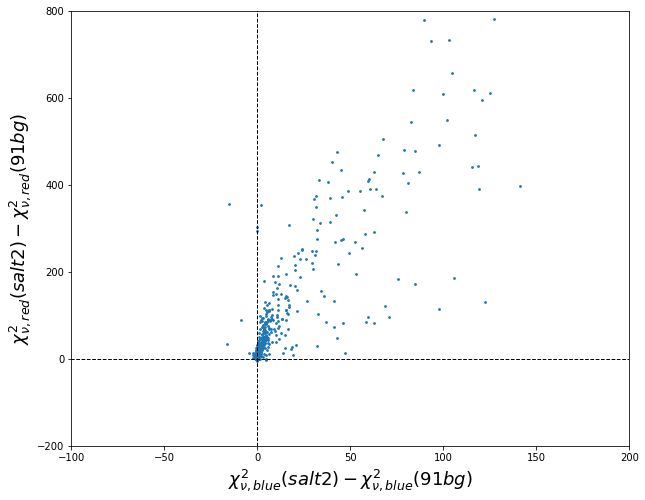

In [201]:
fig=plt.figure(figsize=(10,8))
ax=plt.subplot(111)
x=salt2_b[m_salt2_b]['redchi^2']-sn91bg_b[m_91bg_b]['redchi^2']
y=salt2_r[m_salt2_r]['redchi^2']-sn91bg_r[m_91bg_r]['redchi^2']
ax.scatter(x,y,s=3)
ax.vlines(0,-200,1000,linestyles='dashed',linewidth=1)
ax.hlines(0,-200,1000,linestyles='dashed',linewidth=1)
ax.set_xlim(-100,200)
ax.set_ylim(-200,800)
ax.set_xlabel(r'$\chi^2_{\nu,blue}(salt2)-\chi^2_{\nu,blue}(91bg)$',fontsize=18)
ax.set_ylabel(r'$\chi^2_{\nu,red}(salt2)-\chi^2_{\nu,red}(91bg)$',fontsize=18)

# Comparison of simulated and fitted parameters

In [214]:
data=Table.read('SNcosmo_result/set_z/91bg_all_fit.csv')

(0.6, 1.3)

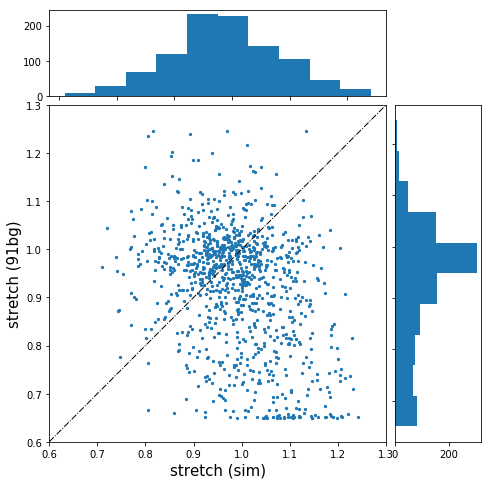

In [215]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_x1'],data['fit_x1'],s=5)
ax1.hist(data['sim_x1'])
ax2.hist(data['fit_x1'],orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('stretch (91bg)',fontsize=15,fontweight='light')
ax.plot(np.arange(0.6,1.4,0.1),np.arange(0.6,1.4,0.1),'k-.',linewidth=1)
ax.set_xlim(0.6,1.3)
ax.set_ylim(0.6,1.3)

(-0.1, 1.1)

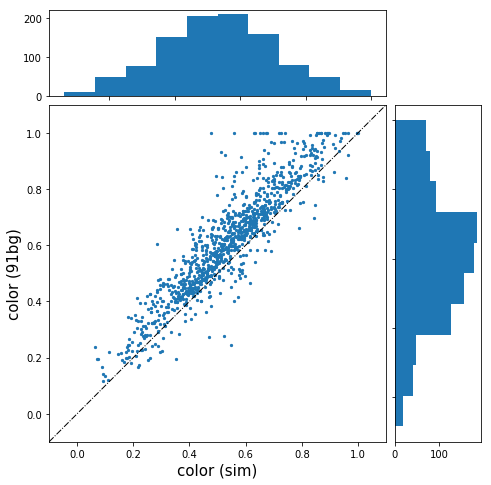

In [216]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_c'],data['fit_c'],s=5)
ax1.hist(data['sim_c'])
ax2.hist(data['fit_c'],orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('color (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('color (91bg)',fontsize=15,fontweight='light')
ax.plot(np.arange(-0.1,1.2,0.1),np.arange(-0.1,1.2,0.1),'k-.',linewidth=1)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

(0.0, 0.4)

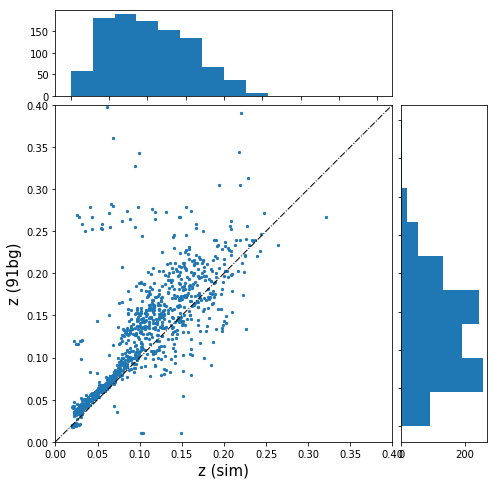

In [184]:
data=Table.read('SNcosmo_result/port91bg_salt2//91bg_all_fit.csv')
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_z'],data['fit_z'],s=5)
ax1.hist(data['sim_z'],np.linspace(0,0.4,15))
ax2.hist(data['fit_z'],np.linspace(0,0.4,10),orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('z (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('z (91bg)',fontsize=15,fontweight='light')
ax.plot(np.arange(0,0.41,0.1),np.arange(0,0.41,0.1),'k-.',linewidth=1)
ax.set_xlim(0.,.4)
ax.set_ylim(0.,.4)

In [73]:
table=read_lc(50003)
model=sncosmo.Model(source=SN91bgSource())
#mask=table['band']!='sdssz'
#table=table[mask]
obs=Table({'time':table['time'],
           'band':table['band'],
           'gain':np.full(len(table),1.0),
           'skynoise':np.zeros(len(table)),
           'zp':table['zp'],
           'zpsys':table['zpsys']})
params={'z':0.050950,'t0':table.meta['t0']}
lcs = sncosmo.realize_lcs(obs, model, [params])
data,result,fitted_model=sncosmo_fit(lcs[0],'91bg','all')
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)